In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time
import json
import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import folium
import json
import requests

minimal_player_count_to_filter = 10

minimal_rating_to_consider = 2000 # When we get to player ranked less than that. we stop
minimal_country_population = 1000000

In [3]:
def scrape_chess_leaderboard_full(page=1):
    url = f"https://www.chess.com/leaderboard/live?page={page}"
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options=options)

    driver.get(url)
    time.sleep(5)  # Wait for JS to load

    rows = driver.find_elements(By.CSS_SELECTOR, "tr.leaderboard-row-show-on-hover")
    data = []

    for row in rows:
        try:
            # Player name
            name_elem = row.find_element(By.CLASS_NAME, "cc-user-username-component")
            name = name_elem.text.strip()
            country = "unknown"
            try:
                # Country code (your method)
                country_div = row.find_element(By.CSS_SELECTOR, "div[class*='country-']")
                country_classes = country_div.get_attribute("class").split()
                country = [c for c in country_classes if c.startswith("country-") and "flags" not in c][0]
                country_code = country.split("-")[1]
            except:
                print(f"failed to get country: name: {name}")
            rating = "-1"
            try:   
                # Rating
                rating_elem = row.find_elements(By.CSS_SELECTOR, "td.leaderboard-table-text-right")[1]
                rating = rating_elem.text.strip()
            except: 
                print(f"Failed to get ranking. Name: {name}")
                
            data.append({
                "Player Name": name,
                "Country Code": country_code,
                "Rating": rating
            })

        except Exception as e:
            print(f"failure: {e}")  # Skip any row that causes an error

    driver.quit()

    return pd.DataFrame(data)



In [4]:
# Example usage
all_data = []
page = 1
while(True):
    print(f"Scraping page {page}")
    df = scrape_chess_leaderboard_full(page)
    all_data.append(df)
    min_value = df["Rating"].min()
    print(f"min: {min_value}")
    page +=1
    if (int(min_value) < minimal_rating_to_consider):
        break

final_df = pd.concat(all_data, ignore_index=True)


Scraping page 1
failed to get country: name: Rud_Makarian
min: 2763
Scraping page 2
min: 2620
Scraping page 3
failed to get country: name: dennisodessa
min: 2532
Scraping page 4
failed to get country: name: VlasoffChess
failed to get country: name: RussianPapaya
failed to get country: name: qus1
min: 2475
Scraping page 5
failed to get country: name: ivanoobsky
failed to get country: name: tnl1984
min: 2418
Scraping page 6
failed to get country: name: tnl1984
failure: cannot access local variable 'country_code' where it is not associated with a value
min: 2365
Scraping page 7
min: 2333
Scraping page 8
failed to get country: name: strdfgggffvv
failed to get country: name: Sasha_Solovev_777
min: 2308
Scraping page 9
failed to get country: name: svss64
min: 2285
Scraping page 10
failed to get country: name: kastorkaru
min: 2260
Scraping page 11
failed to get country: name: LeonidMartynovich
min: 2234
Scraping page 12
min: 2217
Scraping page 13
failed to get country: name: Chesscoachrus
fai

## Group by country

In [5]:
players_by_country = final_df.groupby("Country Code").size().reset_index(name="Player Count")

In [32]:
import json

with open("country_mapping.json", "r", encoding="utf-8") as f:
    country_codes = json.load(f)
with open("countries_population.json", "r", encoding="utf-8") as f:
    country_population = json.load(f)

In [33]:
name_to_population = dict()
for i in country_population:
    name_to_population[i["Country Name"]] = i["Population"]

In [34]:
code_to_name = {entry["id"]: entry["name"] for entry in country_codes}


In [35]:
# Define a function
def country_name(row):
    t = row["Country Code"]
    return code_to_name[int(t)]

final_df["country_name"] = final_df.apply(country_name, axis=1)


In [36]:
final_df

,Player Name,Country Code,Rating,country_name,country_population
0,spicycaterpillar,2,3073,United States,334915000
1,joppie2,101,3044,Netherlands,17877000
2,tptagain,163,3039,Spain,48348000
3,Mykola-Bortnyk,2,3029,United States,334915000
4,0gZPanda,2,3023,United States,334915000
...,...,...,...,...,...
14586,Chessnutnoob,112,1984,Poland,36687000
14587,Janurlich,36,1984,Croatia,3860000
14588,manuveiracandelaria,34,1984,Colombia,52321000
14589,Carbon6580,52,1984,France,68287000


In [37]:
missing_populations = dict()
def country_population(row):
    t = row["country_name"]
    if (t in name_to_population):
        return name_to_population[t]
    if (t in missing_populations):
        missing_populations[t] = missing_populations[t]+1
    else:
        missing_populations[t]=1
    return 1
    

final_df["country_population"] = final_df.apply(country_population, axis=1)


In [38]:
missing_populations

{'Anguilla',
 'Antigua & Barbuda',
 'Basque Country',
 'Brunei',
 'Canary Islands',
 'Cape Verde',
 'Catalonia',
 'Cayman Islands',
 'Chinese Taipei',
 'Congo - Brazzaville',
 'Congo - Kinshasa',
 'Cura\\u00e7ao',
 'England',
 'European Union',
 'Falkland Islands',
 'French Guiana',
 'Galicia',
 'Hong Kong SAR China',
 'International',
 'Isle of Man',
 'Jersey',
 'Macao SAR China',
 'Micronesia',
 'Niue',
 'Olympic',
 'Palestine',
 'Paralympic',
 'R\\u00e9union',
 'S\\u00e3o Tom\\u00e9 & Pr\\u00edncipe',
 'Scotland',
 'Sint Maarten',
 'South Georgia',
 'St. Kitts & Nevis',
 'St. Pierre & Miquelon',
 'St. Vincent & Grenadines',
 'Trinidad & Tobago',
 'Turks & Caicos Islands',
 'U.S. Virgin Islands',
 'Vatican City',
 'Wales',
 'Western Sahara',
 '\\u00c5land Islands'}

In [12]:
final_df

,Player Name,Country Code,Rating,country_name,country_population
0,spicycaterpillar,2,3073,United States,334915000
1,joppie2,101,3044,Netherlands,17877000
2,tptagain,163,3039,Spain,48348000
3,Mykola-Bortnyk,2,3029,United States,334915000
4,0gZPanda,2,3023,United States,334915000
...,...,...,...,...,...
14586,Chessnutnoob,112,1984,Poland,36687000
14587,Janurlich,36,1984,Croatia,3860000
14588,manuveiracandelaria,34,1984,Colombia,52321000
14589,Carbon6580,52,1984,France,68287000


In [13]:
players_by_country = final_df.groupby("country_name").size().reset_index(name="Player Count")

In [14]:
players_by_country

,country_name,Player Count
0,Afghanistan,11
1,Albania,57
2,Algeria,44
3,American Samoa,2
4,Andorra,6
...,...,...
215,Western Sahara,1
216,Yemen,10
217,Zambia,26
218,Zimbabwe,19


In [15]:
players_by_country["country_population"] = players_by_country.apply(country_population, axis=1)

missing population: Anguilla
missing population: Antigua & Barbuda
missing population: Basque Country
missing population: Bosnia & Herzegovina
missing population: Brunei
missing population: Canary Islands
missing population: Cape Verde
missing population: Catalonia
missing population: Cayman Islands
missing population: Chinese Taipei
missing population: Congo - Brazzaville
missing population: Congo - Kinshasa
missing population: Cote Ivoire
missing population: Cura\u00e7ao
missing population: England
missing population: European Union
missing population: Falkland Islands
missing population: French Guiana
missing population: Galicia
missing population: Hong Kong SAR China
missing population: International
missing population: Isle of Man
missing population: Jersey
missing population: Macao SAR China
missing population: Micronesia
missing population: Myanmar (Burma)
missing population: Niue
missing population: North Korea
missing population: Olympic
missing population: Palestine
missing p

In [16]:
players_by_country

,country_name,Player Count,country_population
0,Afghanistan,11,41455000
1,Albania,57,2746000
2,Algeria,44,46164000
3,American Samoa,2,48000
4,Andorra,6,81000
...,...,...,...
215,Western Sahara,1,1
216,Yemen,10,1
217,Zambia,26,20724000
218,Zimbabwe,19,16341000


In [17]:
players_by_country["players per million"] = (players_by_country["Player Count"] / players_by_country["country_population"]) * 1_000_000


In [18]:
players_by_country

,country_name,Player Count,country_population,players per million
0,Afghanistan,11,41455000,2.653480e-01
1,Albania,57,2746000,2.075747e+01
2,Algeria,44,46164000,9.531236e-01
3,American Samoa,2,48000,4.166667e+01
4,Andorra,6,81000,7.407407e+01
...,...,...,...,...
215,Western Sahara,1,1,1.000000e+06
216,Yemen,10,1,1.000000e+07
217,Zambia,26,20724000,1.254584e+00
218,Zimbabwe,19,16341000,1.162720e+00


In [24]:
import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import folium
import json
import requests

# Filter for countries with more than 100 players
players_by_country = players_by_country[players_by_country["Player Count"] > minimal_player_count_to_filter].copy()
players_by_country = players_by_country[players_by_country["country_population"] > minimal_country_population].copy()


In [25]:
players_by_country

,country_name,Player Count,country_population,players per million
0,Afghanistan,11,41455000,0.265348
1,Albania,57,2746000,20.757465
2,Algeria,44,46164000,0.953124
5,Angola,22,36750000,0.598639
8,Argentina,215,45538000,4.721332
...,...,...,...,...
209,Uzbekistan,71,35652000,1.991473
212,Venezuela,75,28301000,2.650083
213,Vietnam,162,100352000,1.614318
217,Zambia,26,20724000,1.254584


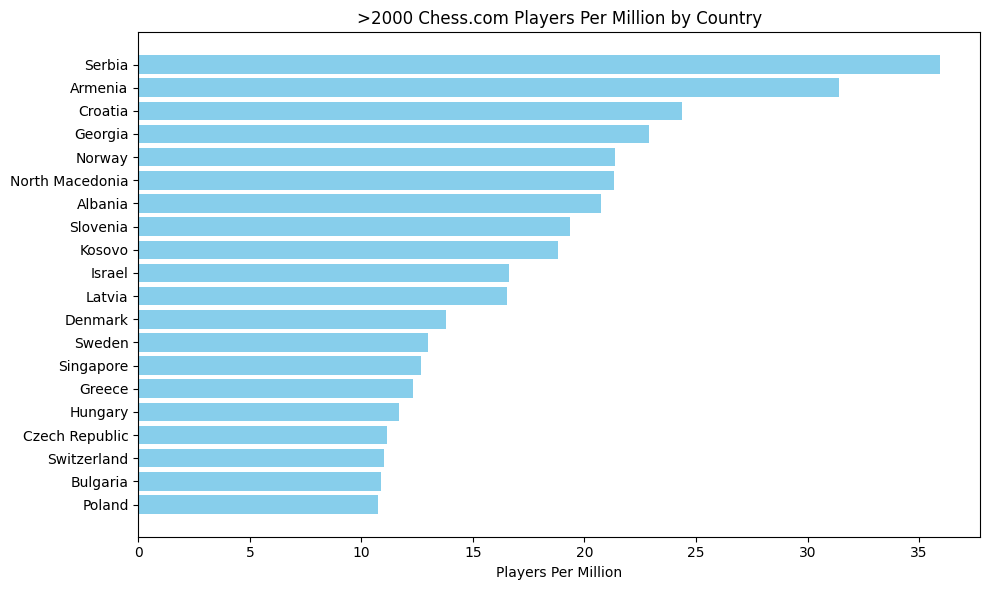

In [26]:
# Sort by value (optional)
df_sorted = players_by_country.sort_values("players per million", ascending=False)[:20]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_sorted["country_name"], df_sorted["players per million"], color='skyblue')
plt.xlabel("Players Per Million")
plt.title(f">{minimal_rating_to_consider} Chess.com Players Per Million by Country")
plt.gca().invert_yaxis()  # Highest value at the top
plt.tight_layout()
plt.show()